# Example

# DAG

https://networkx.org/nx-guides/content/algorithms/dag/index.html

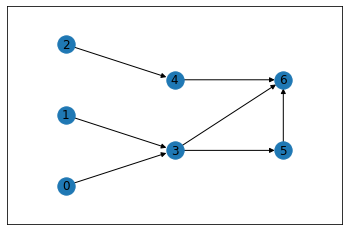

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


G = nx.DiGraph([(0, 3), (1, 3), (2, 4), (3, 5), (3, 6), (4, 6), (5, 6)])

# group nodes by column
left_nodes = [0, 1, 2]
middle_nodes = [3, 4]
right_nodes = [5, 6]

# set the position according to column (x-coord)
pos = {n: (0, i) for i, n in enumerate(left_nodes)}
pos.update({n: (1, i + 0.5) for i, n in enumerate(middle_nodes)})
pos.update({n: (2, i + 0.5) for i, n in enumerate(right_nodes)})

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

nx.draw_networkx(G, pos)#, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
#plt.axis("off")
plt.show()


https://stackoverflow.com/questions/41942109/plotting-the-digraph-with-graphviz-in-python-from-dot-file

In [5]:
from graphviz import Source
temp = """
digraph G{
edge [dir=forward]
node [shape=plaintext]

0 [label="0 (None)"]
0 -> 5 [label="root"]
1 [label="1 (Hello)"]
2 [label="2 (how)"]
2 -> 1 [label="advmod"]
3 [label="3 (are)"]
4 [label="4 (you)"]
5 [label="5 (doing)"]
5 -> 3 [label="aux"]
5 -> 2 [label="advmod"]
5 -> 4 [label="nsubj"]
}
"""
#s = Source(temp, filename="test.gv", format="png")
#s.view()

{'A': ['a', 'b', 'c', 'f'],
 'B': ['a', 'b', 'c', 'f', 'e'],
 'C': ['a', 'b', 'c'],
 'D': ['a', 'b', 'c', 'f', 'g'],
 'E': ['a', 'b', 'c', 'f', 'g']}


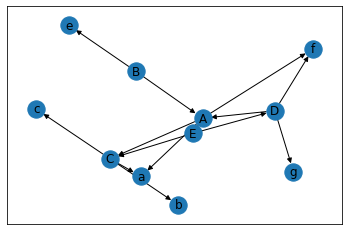

In [6]:
def flatten_deps(deps, BASE_LIST, RAW_DICT):
    new_deps = []
    for d in deps:
        # if a base param
        if d in BASE_LIST:
            # and not et in deps : add it
            if d not in new_deps:
                new_deps.append(d)
            # if already in new deps, go to next d
            else:
                continue
        # if not a base param, it has its param list
        else:
            deps = RAW_DICT[d]
            new_deps = flatten_deps(deps, BASE_LIST, RAW_DICT)
    return new_deps


def flatten_dep_dict(RAW_DICT, BASE_LIST):
    FLAT_DICT = {}
    for k, v in RAW_DICT.items():
        FLAT_DICT[k] = flatten_deps(v, BASE_LIST, RAW_DICT)
    return FLAT_DICT
    
BASE_LIST = ["a", "b", "c", "d", "e", "f", "g"]
    
RAW_DICT = {"C":["a", "b", "c"],
            "B":["A", "e"], 
            "A":["C", "a", "f"],
            "D":["f", "A", "g"],
            "E":["A", "C", "D"],
           }

FLAT_DICT = flatten_dep_dict(RAW_DICT, BASE_LIST)

pprint.pprint(FLAT_DICT)

def dict_to_list_of_edges(RAW_DICT):
    list_of_diredges = []
    for k, v in RAW_DICT.items():
        for d in v:
            list_of_diredges.append((k, d))
    return list_of_diredges


def get_DAG_depth(RAW_DICT):
    list_of_diredges = dict_to_list_of_edges(RAW_DICT)

    G = nx.DiGraph(list_of_diredges)
    m=0
    for k, v in RAW_DICT.items():
        d = nx.shortest_path_length(G,k)
        max_dep = max(d.values())
        if max_dep > m:
            m = max_dep

    return m

def plot_DAG(RAW_DICT):

    list_of_diredges = dict_to_list_of_edges(RAW_DICT)

    G = nx.DiGraph(list_of_diredges)
    nx.draw_networkx(G)
    
def write_DAG_as_dot(RAW_DICT):
    list_of_diredges = dict_to_list_of_edges(RAW_DICT)

    G = nx.DiGraph(list_of_diredges)
    write_dot(G, "test.dot")
    
plot_DAG(RAW_DICT)
#write_DAG_as_dot(RAW_DICT)

# Model

In [1]:
from physipy import units, s, m, asqarray
from physipy.qwidgets.qt import QuantityQtSlider
from physipy.quantity.utils import cached_property_depends_on

V = units["V"]
ohm = units["ohm"]
F = units["F"]

import numpy as np

import time

In [4]:
def register_deps(name, deps):
    def decorator(f):
        f.deps = (name, deps)
        return f
    return decorator

class RegisteringType(type):
    def __init__(cls, name, bases, attrs):
        for key, val in attrs.items():
            deps = getattr(val, 'deps', None)
            if deps is not None:
                print(val.__name__)
                cls.curves[val.__name__] = deps
                
class ParamDescriptor():
    def __init__(self, min, max):
        self.min = min
        self.max = max
        
    def __set_name__(self, owner, name):
        # self.R
        self.public_name = name
        # actually refers to self._R_w
        self.private_name = '_' + name + "_observable_proxy_descriptor"
        
    def __set__(self, obj, qvalue):
        
        # to add the attribute name to the list of base params
        # but this means the check will be done at each __set__ 
        # so it slow down computation
        #if self.public_name not in obj.params:
        #    obj.params.append(self.public_name)
        if self.min <= qvalue <= self.max:
            setattr(obj, self.private_name, qvalue)
        else:
            raise ValueError
    
    def __get__(self, obj, objtype=None):
        value = getattr(obj, self.private_name)
        return value
    
    


class ModelRC(metaclass=RegisteringType):
    
    curves = {}
    #params = []
    
    R  = ParamDescriptor(0*ohm, 10*ohm)
    C  = ParamDescriptor(0*F, 10*F)
    Ve = ParamDescriptor(0*V, 10*V)
    u0 = ParamDescriptor(0*V, 10*V)

    def __init__(self, Ve, R, C, u0=0*V, ech_t=np.arange(100)*s):
        self.R = R
        self.C = C
        self.Ve = Ve
        self.u0 = u0
        self.ech_t = ech_t
        
        # alternative : in ParamDescriptor : if self.public_name not in obj.params:obj.params.append(self.public_name)
        #for i in vars(self).keys():
        #    if i.endswith("_observable_proxy_descriptor"):
        #        self.params.append(i.split("_")[1])
        
        # just add a params dict that describes the sliders...
        self.params = {
            "R"  :{"min":0*ohm, "max":10*ohm, "value":self.R},
            "C"  :{"min":0*F,   "max":10*F,   "value":self.C},
            "Ve" :{"min":0*V,   "max":10*V,   "value":self.Ve},
            "u0" :{"min":0*V,   "max":10*V,   "value":self.u0},
        }
        
        
    # ... and a method to provide all the curves you want to plot
    def get_curves(self):
        curves = {
            "xys_start_solved":{"xys":self.xy_response, "pen_color":"r",}, # "deps":["R", "C", "Ve", "u0"]
            "convergence_line":{"xys":self.xy_convergence, "pen_color":"g",},# "deps":["Ve"]},
            "slope_at_start":  {'xys':self.xy_slope_at_start, "pen_color":'b'},
        }
        return curves


    #@cached_property_depends_on('R', 'C') # will not recompute if R and C state are unchanged
    @register_deps("tau", ["R", "C"])
    def tau(self):
        return self.R * self.C
    
    @register_deps("convergence", ["Ve"])
    def xy_convergence(self):
        return asqarray([0*s, np.max(self.ech_t)]), asqarray([self.Ve, self.Ve])
    
    #@cached_property_depends_on('u0', 'Ve', "tau") # will not recompute if R and C state are unchanged
    @register_deps("slope at start", ["u0", "Ve", "tau"])#"R", "C"])
    def xy_slope_at_start(self):
        xs = asqarray([0*s, self.tau, self.tau])
        ys = asqarray([self.u0, self.Ve, self.u0])
        return xs, ys
    
    @register_deps("response", ["u0", "Ve", "tau"])#"R", "C"])
    def xy_response(self, ech_t=None):
        if ech_t is None:
            ech_t = self.ech_t

        xs = ech_t
        ys = (self.u0 - self.Ve) * np.exp(-ech_t/self.tau) + self.Ve
        return xs, ys 
    

tau
xy_convergence
xy_slope_at_start
xy_response


In [5]:
model = ModelRC(0*V, 0*ohm, 3*F)
print(model.params)
print(model.R)
model.R = 3*ohm
print(model.R)

{'R': {'min': <Quantity : 0.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, 'max': <Quantity : 10.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, 'value': <Quantity : 0.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>}, 'C': {'min': <Quantity : 0.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, 'max': <Quantity : 10.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, 'value': <Quantity : 3.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>}, 'Ve': {'min': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>, 'max': <Quantity : 10.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>, 'value': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>}, 'u0': {'min': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>, 'max': <Quantity : 10.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>, 'value': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>}}
0.0 kg*m**2/(A**2*s**3)
3.0 kg*m**2/(A**2*s**3)


In [7]:
import pprint
pprint.pprint(model.curves)
pprint.pprint(model.params)

{'tau': ('tau', ['R', 'C']),
 'xy_convergence': ('convergence', ['Ve']),
 'xy_response': ('response', ['u0', 'Ve', 'tau']),
 'xy_slope_at_start': ('slope at start', ['u0', 'Ve', 'tau'])}
{'C': {'max': <Quantity : 10.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>,
       'min': <Quantity : 0.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>,
       'value': <Quantity : 3.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>},
 'R': {'max': <Quantity : 10.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>,
       'min': <Quantity : 0.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>,
       'value': <Quantity : 0.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>},
 'Ve': {'max': <Quantity : 10.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>,
        'min': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>,
        'value': <Quantity : 0.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>},
 'u0': {'max': <Quantity : 10.0 kg*m**2/(A*s**3), symbol=V*UndefinedSymbol>,
        'min': <Quanti

In [38]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import sys
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import QSlider, QWidget, QApplication, QVBoxLayout, QLabel, QMainWindow
from PyQt5.QtWidgets import QApplication, QHBoxLayout, QLabel, QSizePolicy, QSlider, QSpacerItem, \
    QVBoxLayout, QWidget, QLineEdit, QComboBox
import PyQt5.QtWidgets
import PyQt5.QtCore as QtCore



import pyqtgraph as pg
# Enable antialiasing for prettier plots
pg.setConfigOptions(antialias=True)
import pyqtgraph.console

class VuePyQt(QMainWindow):#QWidget):
    def __init__(self, model, parent = None):
        super(VuePyQt, self).__init__()

        self.model = model

        layout = QVBoxLayout()
        self.setContentsMargins(0, 0, 0, 0) 
        #self.setSpacing(0)
        
        # spent 3 days on this : https://stackoverflow.com/questions/2295290/what-do-lambda-function-closures-capture
        widgets = []
        for key, value in model.params.items():
            
            # create slider
            if hasattr(value["min"], "value"):
                slider = QuantityQtSlider(value["min"], 
                                          value["max"],
                                          value=value["value"], descr=key)
            else:
                slider = QuantityQtSlider(quantify(value["min"]), 
                                          quantify(value["max"]),
                                          value=quantify(value["value"]), descr=key)

            # add slider to Vue
            setattr(self, key+"_slider", slider)
            # connect slider's value to model's value
            getattr(self, key+"_slider").qtslider.valueChanged.connect(lambda qtvalue, key=key:self.set_attr(self.model, key))#(lambda qtvalue:self.update_model_param_value(qtvalue, slider, key))
            # make slider to update all curves
            #getattr(self, key+"_slider").qtslider.valueChanged.connect(lambda qtvalue:self.update_traces(qtvalue))
            
            # make slider to update dependent traces
            for k, v in self.model.curves.items():
                if key in v[1]: # loop over parameter list
                    func = getattr(self.model, k)
                    def _upd(qt_value):
                        xs, ys = func()
                        self.traces[name].setData(xs.value,ys.value)
                    getattr(self, key+"_slider").qtslider.valueChanged.connect(_upd)
            
            
            

            widgets.append(slider)
            
        for w in widgets:
            layout.addWidget(w)

        layout.setAlignment(QtCore.Qt.AlignTop)
        
        # to remove margins 
        layout.setContentsMargins(0, 0, 0, 0) #left top right bot
        # to remove space between each HBox
        layout.setSpacing(0)
        
        self.win = pg.GraphicsWindow(title="Basic plotting examples")

        self.canvas = self.win.addPlot(title="Plot11", row=1, col=1,)# axisItems={"bottom":sp_xaxis})
        self.canvas.setLabel('left', 'Y-axis Values')
        self.canvas.addLegend()
        self.canvas.showGrid(x=True, y=True)
        
        self.traces = dict()
        
        for name, trace_dict in self.model.get_curves().items():
            func = trace_dict["xys"]
            xs, ys = func()
            pen_color = trace_dict["pen_color"]
            self.trace(name, xs, ys, pen=pen_color)
        

        layout.addWidget(self.win)

        widget = QWidget()
        widget.setLayout(layout)
        self.setCentralWidget(widget)

    def set_attr(self, obj, key):
        setattr(obj, key, getattr(self, key+"_slider").value)

    def update_model_param_value(self, qtvalue, slider, key):
        setattr(self.model, key, slider.value)
    
    def trace(self, name, dataset_x,dataset_y, pen="y", symbol="o"):
        if name in self.traces:
            self.traces[name].setData(dataset_x.value,dataset_y.value)
        else:
            self.traces[name] = self.canvas.plot(x=dataset_x.value, y=dataset_y.value, pen=pen, width=3, symbol=symbol, name=name, symbolBrush=pen)
            #pen =(0, 0, 200), symbolBrush =(0, 0, 200),
                      #symbolPen ='w', symbol ='o', symbolSize = 14, name ="symbol ='o'")
    
    #def update_trace_generator(self, name, curve_func):
    #    def update_func():
    #        xs, ys = curve_func()
    #        self.trace(name, xs, ys)
    #    return update_func
    
    #def update_traces(self, qtvalue):
    #    for name, trace_dict in self.model.get_curves().items():
    #        func = trace_dict["xys"]
    #        xs, ys = func()
    #        pen_color = trace_dict["pen_color"]
    #        self.trace(name, xs, ys, pen=pen_color)


In [ ]:
        
def main():
    app = QApplication(sys.argv)
    
    # to define a custom color
    from PyQt5.QtGui import QPalette
    palette = QPalette()
    palette.setColor(QPalette.ButtonText, Qt.red)
    app.setPalette(palette)
    
    Ve = 5 * V
    R  = 3 * ohm
    C  = 2 * F
    
    model = ModelRC(Ve, R, C)
    print(model.R, model.C, model.Ve, model.u0)

    vue = VuePyQt(model)
    vue.show()
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

3.0 kg*m**2/(A**2*s**3) 2.0 A**2*s**4/(kg*m**2) 5.0 kg*m**2/(A*s**3) 0.0 kg*m**2/(A*s**3)
update response
getting tau


/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_79093/2343443962.py:73: DeprecationWarning: GraphicsWindow is deprecated, use GraphicsLayoutWidget instead,will be removed in 0.13
  self.win = pg.GraphicsWindow(title="Basic plotting examples")
